# Simple ANOVA Examples

## Introduction

This is an example of working an ANOVA, with a really simple dataset, using ```statsmodels```.  In some cases, we perform explicit computation of model parameters, and then compare them to the ```statsmodels``` answers. The examples are taken from "Facts from Figures" by M. J. Moroney, a Pelican book from before the days of computers.

-----
## Initialize Environment

In [79]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [80]:
%reload_ext lab_black

In [81]:
%matplotlib inline

In [82]:
import pandas as pd
import numpy as np
import seaborn as sn

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM

from patsy import dmatrices

from patsy.contrasts import Treatment
from patsy.contrasts import Sum
from patsy.contrasts import Diff


import warnings

---
# Facts from Figures Chap 19

## Dataset 1

This dataset is taken from "Facts from Figures", by M.J.Moroney, Page 374.  We have four samples (each of five items) take from some population.  We will look at the between sample variation, as opposed to the within sample variation.

We first look at the dataset in "wide" format (with one column for each sample), and create a ```pandas``` dataframe 

In [83]:
S1 = [2, 3, 1, 3, 1]
S2 = [3, 4, 3, 5, 0]
S3 = [6, 8, 7, 4, 10]
S4 = [5, 5, 5, 3, 2]

In [84]:
df_dict = {"S1": S1, "S2": S2, "S3": S3, "S4": S4}

In [85]:
data = pd.DataFrame(df_dict)

In [86]:
data

,S1,S2,S3,S4
0,2,3,6,5
1,3,4,8,5
2,1,3,7,5
3,3,5,4,3
4,1,0,10,2


In [87]:
data.columns

Index(['S1', 'S2', 'S3', 'S4'], dtype='object')

Show the mean of each sample

In [88]:
for name in data.columns:
    print(name, data[name].mean())

S1 2.0
S2 3.0
S3 7.0
S4 4.0


Another way to show means, usimg ```pandas``` methods operating on the dataframe as a whole

In [89]:
data.mean()

S1    2.0
S2    3.0
S3    7.0
S4    4.0
dtype: float64

Get the mean of the whole dataset  (works because each sample has the same number of observation = 5)

In [90]:
mu = data.mean().mean()
mu

4.0

Create a new "long" dataset, where sample number is now an attribute (not a column identity).  Further, we tell ```pandas``` thet the sample number is a categorical variable, not numeric

In [91]:
values = (
    list(data["S1"])
    + list(data["S2"])
    + list(data["S3"])
    + list(data["S4"])
)
sample = (
    list(np.ones(5) * 1)
    + list(np.ones(5) * 2)
    + list(np.ones(5) * 3)
    + list(np.ones(5) * 4)
)

In [92]:
# get a dict holding names of columns and associated data

dict2 = {"values": values, "sample": sample}

# build dataframe
data_long = pd.DataFrame(dict2)

# declare sample to be a categorical variable
data_long["sample"] = data_long["sample"].astype(int)
data_long["sample"] = data_long["sample"].astype("category")

# show the first and last few rows
print(data_long.head(), "\n", data_long.tail())

   values sample
0       2      1
1       3      1
2       1      1
3       3      1
4       1      1 
     values sample
15       5      4
16       5      4
17       5      4
18       3      4
19       2      4


----
### Compute Sums of Squares


We create a number of sum of squares: 

- ```sst``` is the sum of squares of variation across the whole dataset, against the global mean
- ```ssm``` is the sum of squares of the difference between the Sample Mean, and the Global Mean, for all observations (__Between Sample Variation__)
- ```sse``` is the  sum of squares of the difference between an observation Value and the Sample Mean, for all observations (__Within Sample Variation__)


In [93]:
#
#  Get total sum of squares Values against Global Mean
#
mean_v = data_long["values"].mean()  #
#  Get the within sample sum of squares of an observation Value and the Sample Mean, for all observations
#


sst = sum(
    (data_long["values"] - mean_v)
    * (data_long["values"] - mean_v)
)
sst

116.0

In [94]:
#
# Get the between Sample sum of squares
# get the square of difference between the Sample Mean, and the Global Mean, for all observations
#
ssm = sum(
    [
        (mean_v - data.mean()[i - 1]) ** 2
        for i in data_long['sample'].astype(int)
    ]
)
ssm

70.0

In [95]:
#
#  Get the within sample sum of squares of an observation Value and the Sample Mean, for all observations
#

sse = sum(
    [
        (v - data.mean()[s - 1]) ** 2
        for v, s in zip(
            data_long['values'],
            data_long['sample'].astype(int),
        )
    ]
)
sse

46.0

- For the sample as whole, the Degrees of Freedom = 19 (20 observations)
- For the between-sample variation, the Degrees of Freedom = 3 (4 sample -1)
- For the within-sample variation, the Degrees of Freedom = 16 ( 4 sample, each of 5 observations = 4 * (5-1)

The variance estimates for each of ```sst```, ```ssm``` and ```sse``` are:

In [96]:
print(
    f'Variance Estimates (total, between sample, within sample): {(sst / 19):10.5f}, {(ssm / 3):10.5f}, {(sse / 16):10.5f}'
)

Variance Estimates (total, between sample, within sample):    6.10526,   23.33333,    2.87500


The ratio of the between sample variance to the within sample variance (i.e. how much bigger is the spread of sample means vs spread of values in a single sample) is (under the Null Hypothesis) an F statistic

In [97]:
print(f' F value = {(ssm / 3)/((sse / 16)):10.5f}')

 F value =    8.11594


----
### Visualize Dataset

We use ```pandas``` platting methods to show an overlapping set of histograms, one for each sample, and one for the total dataset.  It turns out that this is __not__ a startlingly good way of representing the data

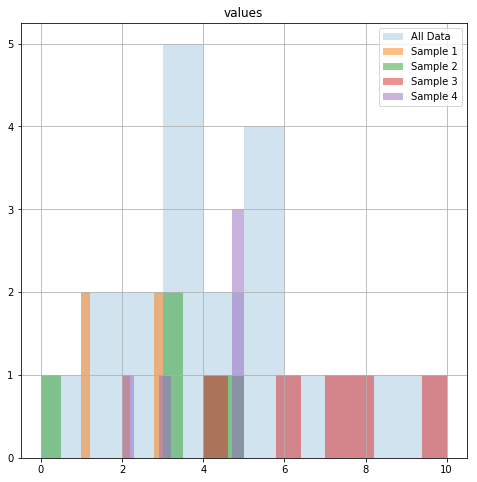

In [98]:
fig, ax = plt.subplots(figsize=(8, 8))

# show histogram for whole dataset
data_long.hist('values', ax=ax, alpha=0.2, label='All Data')

# show histogram for each sample
for i in [1, 2, 3, 4]:
    data_long[data_long['sample'] == i].hist(
        'values', ax=ax, alpha=0.5, label='Sample ' + str(i)
    )
# end for
ax.legend(loc='best')

Lets try again, with the old standard, a scatter plot.  We show global mean, and each sample mean, and each datapoint

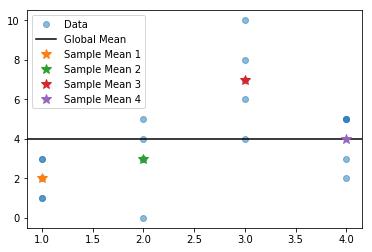

In [99]:
_ = plt.plot(
    data_long['sample'].astype(int),
    data_long['values'],
    'o',
    alpha=0.5,  # allows overlapping points to be distinguished
    label='Data',
)

_ = plt.axhline(
    data_long['values'].mean(),
    color='k',
    label='Global Mean',
)
for i in [1, 2, 3, 4]:
    plt.plot(
        i,
        data_long[data_long['sample'] == i][
            'values'
        ].mean(),
        '*',
        label='Sample Mean ' + str(i),
        alpha=1,
        markersize=10,
    )

# end for
_ = plt.legend(loc='best')


------
### Fit Linear Model

Based upon the graphs above, we first normalize the dataset, by subtracting the Global Mean from each value.

We then specify a model 

- value s= beta_1 * sample_1 + beta_2 * sample_2 + beta_3 * sample_3 + beta_4 * sample_4 + Normal(0,Std_err)

where sample_i = 1 if the observation is in the i_th sample, and 0 otherwise  (known as one-hot type encoding)

When we call ```ols```, we have to specify that we do __not__ want an intercept term by adding "-1" to the formula we use

Under the Null Hypothesis (H0), each observation of each samples are drawn from the same distribution, so beta_i will 0, each each i in 1,2,3,4

In [100]:
data_long_z = data_long.copy()
data_long_z['values'] = data_long_z['values'] - mean_v

res2_2 = ols("values ~ sample -1", data=data_long_z).fit()
res2_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     8.116
Date:                Wed, 01 Apr 2020   Prob (F-statistic):            0.00164
Time:                        14:29:08   Log-Likelihood:                -36.708
No. Observations:                  20   AIC:                             81.42
Df Residuals:                      16   BIC:                             85.40
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sample[1]     -2.0000      0.758     -2.638      0.018      -3.607      -0.393
sample[2]     -1.0000      0.758     -1.319      0.206      -2.607       0.607
sample[3]      3.0000      0.758      3.956      0.001       1.393       4.607
sample[4]           0      0.758          0      1.000      -1.607       1.607
==============================================================================
Omnibus:                        0.631   Durbin-Watson:                   2.348
Prob(Omnibus):                  0.729   Jarque-Bera (JB):                0.468
Skew:                          -0.344   Prob(JB):                        0.791
Kurtosis:                       2.703   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see from the ```P>|t|``` column above that sample 2 and 4 do not have values significantly (at 5%) different from the overall population, but samples 1 and 3 do appear to differ

We can confirm various values held in the RegressionResults object

Compare to 

> ```Variance Estimates (total, between sample, within sample):    6.10526,   23.33333,    2.87500```

In [101]:
print(
    f' Mean Square Total           {res2_2.mse_total:10.5f}'
)
print(
    f' Mean Square Between Samples {res2_2.mse_model:10.5f}'
)
print(
    f' Mean Square Within Samples  {res2_2.mse_resid:10.5f}'
)

 Mean Square Total              6.10526
 Mean Square Between Samples   23.33333
 Mean Square Within Samples     2.87500


The standard error for a sample of 5 items will be a factor of ```1/sqrt(5)``` smaller the the standard error for a single item (the ```RegressionResults.summary()``` displayed value agrees)

In [102]:
print(
    f' Mean of Sample of 5 Standard Error = {np.sqrt(res2_2.mse_resid / 5):10.5f}'
)

 Mean of Sample of 5 Standard Error =    0.75829


Get probability of getting sample means as far from zero as we actually have. Coefficient 1 and 3 are very unlikely to have been drawn from a population having the same mean as the rest of the samples.  This agrees with the results in the RegressionResults summary above

In [103]:
(
    stats.t.sf(2.638, 16) * 2,
    stats.t.sf(1.319, 16) * 2,
    stats.t.sf(3.956, 16) * 2,
    stats.t.sf(0, 16) * 2,
)

(0.017901874492978635, 0.2057360634914765, 0.0011320979947368858, 1.0)

Get 5% confidence limits

In [104]:
lower_ci = 0.758 * stats.t.ppf(0.025, 16)
upper_ci = 0.758 * stats.t.ppf(0.975, 16)
lower_ci, upper_ci

(-1.6068882168095264, 1.6068882168095264)

Text(0, 0.5, 'Coefficient of Normalized Sample\n(= Normalized Sample Mean) ')

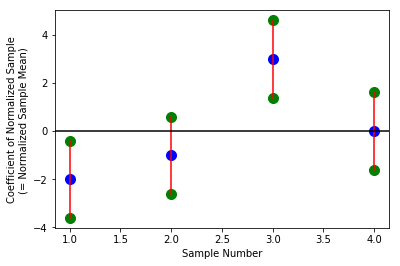

In [105]:
for i in [1, 2, 3, 4]:
    plt.plot(
        i,
        res2_2.params.iloc[i - 1],
        'bo',
        label='Sample Coeff ' + str(i),
        alpha=1,
        markersize=10,
    )
    plt.plot(
        i,
        res2_2.params.iloc[i - 1] + lower_ci,
        'go',
        alpha=1,
        markersize=10,
    )
    plt.plot(
        i,
        res2_2.params.iloc[i - 1] + upper_ci,
        'go',
        alpha=1,
        markersize=10,
    )
    plt.plot(
        [i, i],
        [
            res2_2.params.iloc[i - 1] + lower_ci,
            res2_2.params.iloc[i - 1] + upper_ci,
        ],
        'r-',
        alpha=1,
        markersize=10,
    )
# end for
_ = plt.axhline(0, color='k')
plt.xlabel('Sample Number')
plt.ylabel(
    'Coefficient of Normalized Sample\n(= Normalized Sample Mean) '
)

We get the same results when we get predictions from our OLD linear model

In [106]:
for i in [1, 2, 3, 4]:
    gp = res2_2.get_prediction({'sample': i})

    print(gp.summary_frame())
# end for

   mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0  -2.0  0.758288      -3.607498      -0.392502     -5.937549      1.937549
   mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0  -1.0  0.758288      -2.607498       0.607498     -4.937549      2.937549
   mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0   3.0  0.758288       1.392502       4.607498     -0.937549      6.937549
   mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0   0.0  0.758288      -1.607498       1.607498     -3.937549      3.937549


### Non-Normalized Model

We could choose not to normalize our model to zero mean  (at the small inconvenience of making the coefficients a little harder to understand; they are now offsets from the mean of Sample 1), and we would get exactly the same results

In [107]:
res2_3 = ols("values ~ sample ", data=data_long).fit()
res2_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     8.116
Date:                Wed, 01 Apr 2020   Prob (F-statistic):            0.00164
Time:                        14:29:09   Log-Likelihood:                -36.708
No. Observations:                  20   AIC:                             81.42
Df Residuals:                      16   BIC:                             85.40
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.0000      0.758      2.638      0.018       0.393       3.607
sample[T.2]     1.0000      1.072      0.933      0.365      -1.273       3.273
sample[T.3]     5.0000      1.072      4.663      0.000       2.727       7.273
sample[T.4]     2.0000      1.072      1.865      0.081      -0.273       4.273
==============================================================================
Omnibus:                        0.631   Durbin-Watson:                   2.348
Prob(Omnibus):                  0.729   Jarque-Bera (JB):                0.468
Skew:                          -0.344   Prob(JB):                        0.791
Kurtosis:                       2.703   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
# get predictions of the mean for all our samples

for i in [1, 2, 3, 4]:
    gp = res2_3.get_prediction({'sample': i})

    print(gp.summary_frame())
# end for

   mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0   2.0  0.758288       0.392502       3.607498     -1.937549      5.937549
   mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0   3.0  0.758288       1.392502       4.607498     -0.937549      6.937549
   mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0   7.0  0.758288       5.392502       8.607498      3.062451     10.937549
   mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0   4.0  0.758288       2.392502       5.607498      0.062451      7.937549


The Linear Model ANOVA method gives the same F value as we explcitly calculated above.

In [109]:
sm.stats.anova_lm(res2_3)

,df,sum_sq,mean_sq,F,PR(>F)
sample,3.0,70.0,23.333333,8.115942,0.001642
Residual,16.0,46.0,2.875000,NaN,NaN


----------------

## DataSet 2

This is taken from "Facts from Figures", page 380.  We have data on price bid on the same goods, packaged in 4 different ways.  We wish to determine if package affects price significantly.

Set up our ```pandas``` dataframe, declaring ```pack``` to be a categorical variable

In [110]:
value = (
    [66, 82, 60, 50, 60, 90]
    + [42, 66, 30, 60, 36, 48]
    + [54, 90, 60, 81, 60, 51]
    + [78, 54, 60, 42, 71, 49]
)
pack = (
    list(np.ones(6) * 1)
    + list(np.ones(6) * 2)
    + list(np.ones(6) * 3)
    + list(np.ones(6) * 4)
)

df_dict = {"value": value, "pack": pack}
data = pd.DataFrame(df_dict)
data["pack"] = data["pack"].astype("category")

In [111]:
data.head()

,value,pack
0,66,1.0
1,82,1.0
2,60,1.0
3,50,1.0
4,60,1.0


Visualize our datasets, plotting value against package numbre , for all our observations.  We also mark our within package means (stars) and global mean (black line).

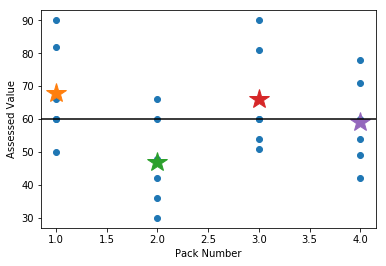

In [112]:
_ = plt.plot(data['pack'].astype(int), data['value'], 'o')
for p in data['pack'].unique():
    plt.plot(
        p,
        data[data['pack'] == p]['value'].mean(),
        '*',
        markersize=20,
    )

# end for
_ = plt.axhline(data['value'].mean(), color='k')
_ = plt.xlabel('Pack Number')
_ = plt.ylabel('Assessed Value')

### Fit a Linear Model

In [113]:
res3 = ols("value ~ pack", data=data).fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     2.533
Date:                Wed, 01 Apr 2020   Prob (F-statistic):             0.0860
Time:                        14:29:10   Log-Likelihood:                -96.213
No. Observations:                  24   AIC:                             200.4
Df Residuals:                      20   BIC:                             205.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      68.0000      5.961     11.408      0.000      55.566      80.434
pack[T.2.0]   -21.0000      8.430     -2.491      0.022     -38.585      -3.415
pack[T.3.0]    -2.0000      8.430     -0.237      0.815     -19.585      15.585
pack[T.4.0]    -9.0000      8.430     -1.068      0.298     -26.585       8.585
==============================================================================
Omnibus:                        5.096   Durbin-Watson:                   3.003
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                2.179
Skew:                           0.412   Prob(JB):                        0.336
Kurtosis:                       1.776   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [114]:
for i in [1, 2, 3, 4]:
    gp = res3.get_prediction({'pack': i})

    print(gp.summary_frame())
# end for

   mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0  68.0  5.960984      55.565605      80.434395     35.101682    100.898318
   mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0  47.0  5.960984      34.565605      59.434395     14.101682     79.898318
   mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0  66.0  5.960984      53.565605      78.434395     33.101682     98.898318
   mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0  59.0  5.960984      46.565605      71.434395     26.101682     91.898318


### Perform ANOVA

We see that the F value this large would be seen about 9 times out of 100, so at the 5% level, we cannot reject the Null Hypothesis that packaging has no effect on valuation of the goods.

In [115]:
anv = sm.stats.anova_lm(res3)
anv

,df,sum_sq,mean_sq,F,PR(>F)
pack,3.0,1620.0,540.0,2.532833,0.086028
Residual,20.0,4264.0,213.2,NaN,NaN


### Explicit F Calculation

In [116]:
#
#  Get total sum of squares Values against Global Mean
#

mean_v = data["value"].mean()
sst = sum(
    (data["value"] - mean_v) * (data["value"] - mean_v)
)
sst

5884.0

In [117]:
#
# Get the between Package sum of squares
# get the square of difference between the Package Mean, and the Global Mean, for all observations
#
ssm = sum(
    [
        (mean_v - data[data['pack'] == i]['value'].mean())
        ** 2
        for i in data['pack'].astype(int)
    ]
)
ssm

1620.0

In [118]:
#
#  Get the within Package sum of squares of an observation Value and the Package Mean, for all observations
#

sse = sum(
    [
        (v - data[data['pack'] == p]['value'].mean()) ** 2
        for v, p in zip(
            data['value'], data['pack'].astype(int)
        )
    ]
)
sse

4264.0


- For the sample as whole, the Degrees of Freedom = 23 (224 observations)
- For the between-sample variation, the Degrees of Freedom = 3 (4 packages -1)
- For the within-sample variation, the Degrees of Freedom = 20 ( 4 packages, each of 6 observations = 4 * (6-1))

In [119]:
print(
    f'Variance Estimates (total, between sample, within sample): {(sst / 23):10.5f}, {(ssm / 3):10.5f}, {(sse / 20):10.5f}'
)

Variance Estimates (total, between sample, within sample):  255.82609,  540.00000,  213.20000


In [120]:
print(f' F value = {(ssm / 3)/((sse / 20)):10.5f}')

 F value =    2.53283


The explicitly computed F value agrees with the ```statsmodels``` results

------
## Two Levels of ANOVA

See "Facts from Figures", page 385.  In this example, we have sales results for four  different persons (A, B ,C, D) each selling at three different locations (C = CBD, O = Outskirts, S = Shopping Centre).  The sales results are normalized before the analysis, but this doesn't affect the analysis of significance.

Create our ```pandas``` dataframe

In [121]:
sales = [30, 70, 30, 30, 80, 50, 40, 70, 100, 60, 80, 80]
C = 'C'
O = 'O'
S = 'S'
district = [C, C, C, C, O, O, O, O, S, S, S, S]
A = 'A'
B = 'B'
C = 'C'
D = 'D'
person = [A, B, C, D, A, B, C, D, A, B, C, D]

df_dict = {
    'sales': sales,
    'district': district,
    'person': person,
}
data4 = pd.DataFrame(df_dict)

Visualize the effect different salespersons and locations have on the observations

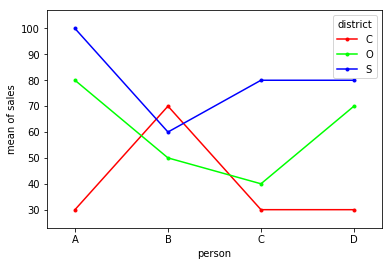

In [122]:
_ = sm.graphics.interaction_plot(
    data4['person'], data4['district'], data4['sales']
)

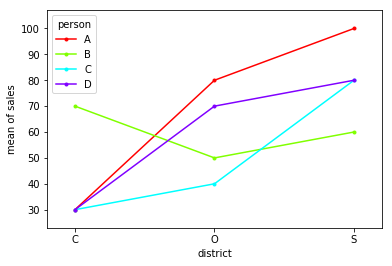

In [123]:
_ = sm.graphics.interaction_plot(
    data4['district'], data4['person'], data4['sales']
)

Normalize the observations (originally to make manual calculation easier - I told you this was old-school)

In [124]:
data4['sales'] = (data4['sales'] - 50) / 10
data4

,sales,district,person
0,-2.0,C,A
1,2.0,C,B
2,-2.0,C,C
3,-2.0,C,D
4,3.0,O,A
5,0.0,O,B
6,-1.0,O,C
7,2.0,O,D
8,5.0,S,A
9,1.0,S,B


Compute the global mean

In [125]:
mean_v = sum(data4['sales']) / len(data4['sales'])
mean_v

1.0

Get the total sum of squares, and its degrees of freedom

In [126]:
total_ss = sum(
    [
        (mean_v - data4['sales'].iloc[i]) ** 2
        for i in range(len(data4))
    ]
)
total_df = len(data4) - 1
total_ss, total_df

(62.0, 11)

Get the between Person sum of squares,  and its degrees of freedom

In [127]:
person_ss = 0
for i in range(len(data4)):
    name = data4['person'].iloc[i]
    person_ss = (
        person_ss
        + (
            mean_v
            - data4[data4['person'] == name]['sales'].mean()
        )
        ** 2
    )
# end for
person_df = len(data4['person'].unique()) - 1
person_ss, person_df

(6.0, 3)

Get the between Districts sum of squares,  and its degrees of freedom

In [128]:
district_ss = 0
for i in range(len(data4)):
    name = data4['district'].iloc[i]
    district_ss = (
        district_ss
        + (
            mean_v
            - data4[data4['district'] == name][
                'sales'
            ].mean()
        )
        ** 2
    )
# end for
district_df = len(data4['district'].unique()) - 1
district_ss, district_df

(32.0, 2)

Get  the residual sum of squares, and its degrees of freedom

In [129]:
residual_ss = total_ss - person_ss - district_ss
residual_df = total_df - person_df - district_df
residual_ss, residual_df

(24.0, 6)

Get the estimated variance for between Person, between Districts, and Residual

In [130]:
person_var = person_ss / person_df
district_var = district_ss / district_df
residual_var = residual_ss / residual_df
person_var, district_var, residual_var

(2.0, 16.0, 4.0)

Declare to ```pandas``` (and hence to ```statsmodels```) that ```person``` and ```district``` are categorical variables.  Then fit a linear model by OLS

In [131]:
data4['person'] = data4['person'].astype('category')
data4['district'] = data4['district'].astype('category')


res_sales = ols(
    'sales ~ district + person', data=data4
).fit()
res_sales.summary()

D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     1.900
Date:                Wed, 01 Apr 2020   Prob (F-statistic):              0.229
Time:                        14:29:11   Log-Likelihood:                -21.186
No. Observations:                  12   AIC:                             54.37
Df Residuals:                       6   BIC:                             57.28
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.554e-15      1.414   -1.1e-15      1.000      -3.460       3.460
district[T.O]     2.0000      1.414      1.414      0.207      -1.460       5.460
district[T.S]     4.0000      1.414      2.828      0.030       0.540       7.460
person[T.B]      -1.0000      1.633     -0.612      0.563      -4.996       2.996
person[T.C]      -2.0000      1.633     -1.225      0.267      -5.996       1.996
person[T.D]      -1.0000      1.633     -0.612      0.563      -4.996       2.996
==============================================================================
Omnibus:                        0.466   Durbin-Watson:                   2.750
Prob(Omnibus):                  0.792   Jarque-Bera (JB):                0.375
Skew:                           0.354   Prob(JB):                        0.829
Kurtosis:                       2.500   Cond. No.                         5.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [132]:
sm.stats.anova_lm(res_sales)

,df,sum_sq,mean_sq,F,PR(>F)
district,2.0,32.0,16.0,4.0,0.078717
person,3.0,6.0,2.0,0.5,0.695895
Residual,6.0,24.0,4.0,NaN,NaN


The conclusion is that the observed F values are not strong enough evidence to reject the Null Hypothesis that there is no affect of salesperson or district on sales results.

-----
## Environment

In [133]:
%watermark -h -iv
%watermark

matplotlib  3.0.2
pandas      1.0.0
seaborn     0.9.0
scipy       1.1.0
numpy       1.15.4
statsmodels 0.9.0
host name: DESKTOP-SODFUN6
2020-04-01T14:29:12+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
